## Detailed article explaination
The detailed code explanation for this article is available at the following link:

https://www.daniweb.com/programming/computer-science/tutorials/543349/integrating-openai-web-search-api-in-langgraph

For my other articles for Daniweb.com, please see this link:

https://www.daniweb.com/members/1235222/usmanmalik57

## Importing and Installing Required Libraries

In [ ]:
# !sudo apt-get update
# !sudo apt-get install -y graphviz libgraphviz-dev

In [ ]:
!pip install -U -q \
langgraph langchain-openai langchain-core \
openai pydantic graphviz pygraphviz


In [ ]:
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import AIMessage, HumanMessage
from google.colab import userdata

## Binding the Web Search Tool to an LLM

In [ ]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

search_tool = {"type": "web_search_preview"}
llm_base    = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key = OPENAI_API_KEY,
    temperature=0,
    use_responses_api=True
)
llm = llm_base.bind_tools([search_tool])

## Creating a LangGraph Graph Using the Web Search Tool

In [ ]:
class WebState(TypedDict):
    input: str
    ai_msg: AIMessage
    output: str

def ask_web(state: WebState) -> WebState:       # State -> Partial
    msg = llm.invoke(state["input"])            # tool call happens automatically
    return {"ai_msg": msg}

def respond(state: WebState) -> WebState:
    return {"output": state["ai_msg"].content}

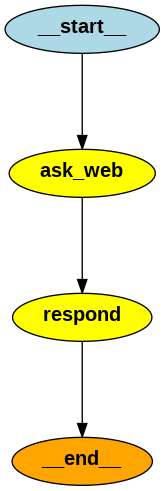

In [ ]:
builder = StateGraph(state_schema=WebState)
builder.add_node("ask_web", ask_web)
builder.add_node("respond", respond)

builder.add_edge(START, "ask_web")              # start → first node
builder.add_edge("ask_web", "respond")          # ask_web → respond

# entry & finish points
builder.set_entry_point("ask_web")
builder.set_finish_point("respond")

graph = builder.compile()


png_bytes = graph.get_graph().draw_png()   # raw binary
display(Image(data=png_bytes, format="png"))

## Searching the Web

In [ ]:
res = graph.invoke({"input": "What is the temperature today in Paris? What is the todays date?"})
print(res['output'][0]['text'])

As of now, the current time in Paris is 2:50 PM on Thursday, May 8, 2025.

8 mai 2025, 14:50:42

The current temperature in Paris is 62°F (17°C), with cloudy conditions.

## Météo à Paris, Ville de Paris, France :
Conditions actuelles : Nuageux, 62°F (17°C)

Prévisions par jour :
* jeudi, mai 8 : Minimale : 49°F (9°C), Maximale : 66°F (19°C), Description : En partie ensoleillé
* vendredi, mai 9 : Minimale : 50°F (10°C), Maximale : 68°F (20°C), Description : Plutôt nuageux
* samedi, mai 10 : Minimale : 55°F (13°C), Maximale : 75°F (24°C), Description : Plutôt ensoleillé et agréable
* dimanche, mai 11 : Minimale : 56°F (13°C), Maximale : 77°F (25°C), Description : Soleil et nuages épars, très chaud et agréable
* lundi, mai 12 : Minimale : 54°F (12°C), Maximale : 71°F (22°C), Description : Nuageux, quelques averses
* mardi, mai 13 : Minimale : 53°F (12°C), Maximale : 72°F (22°C), Description : Un peu de soleil, averses l'après-midi
* mercredi, mai 14 : Minimale : 53°F (12°C), Maximale : 7

In [ ]:
res = graph.invoke({"input": "Who won the champions leage game last night?"})
print(res['output'][0]['text'])

On May 7, 2025, two UEFA Champions League semi-final second-leg matches were played:

**Paris Saint-Germain vs. Arsenal**: Paris Saint-Germain secured a 2-1 victory over Arsenal, advancing to the final with a 3-1 aggregate score. Fabián opened the scoring in the 27th minute, and Achraf Hakimi extended the lead in the 72nd minute. Arsenal's Bukayo Saka scored in the 75th minute, but it wasn't enough to overturn the deficit. PSG's goalkeeper, Gianluigi Donnarumma, made crucial saves, particularly denying Saka late in the game. ([elpais.com](https://elpais.com/deportes/futbol/2025-05-07/psg-arsenal-en-directo-el-partido-de-vuelta-de-las-semifinales-de-la-champions-league-en-vivo.html?utm_source=openai))

**Inter Milan vs. FC Barcelona**: Inter Milan triumphed 4-3 over FC Barcelona, progressing to their eighth Champions League final with a 4-3 aggregate score. Despite Barcelona leading 3-2 in the 90th minute, Inter's Francesco Acerbi scored an equalizer in stoppage time, and Davide Frattes

In [ ]:
sources = [annot['url'] for annot in res['output'][0]['annotations']]
sources


['https://elpais.com/deportes/futbol/2025-05-07/psg-arsenal-en-directo-el-partido-de-vuelta-de-las-semifinales-de-la-champions-league-en-vivo.html?utm_source=openai',
 'https://cadenaser.com/nacional/2025/05/07/lo-veia-todo-negro-casi-me-desmayo-frattesi-explica-que-su-celebracion-del-4-3-estuvo-a-punto-de-pasarle-factura-cadena-ser/?utm_source=openai',
 'https://en.wikipedia.org/wiki/2025_UEFA_Champions_League_final?utm_source=openai',
 'https://www.reuters.com/sports/soccer/psg-see-off-arsenal-earn-second-shot-champions-league-title-2025-05-07/?utm_source=openai',
 'https://elpais.com/deportes/futbol/2025-05-07/psg-arsenal-en-directo-el-partido-de-vuelta-de-las-semifinales-de-la-champions-league-en-vivo.html?utm_source=openai',
 'https://cadenaser.com/nacional/2025/05/07/lo-veia-todo-negro-casi-me-desmayo-frattesi-explica-que-su-celebracion-del-4-3-estuvo-a-punto-de-pasarle-factura-cadena-ser/?utm_source=openai']